In [1]:
#This preprocessing has been adapted from
#https://www.kaggle.com/tunguz/xgboost-starter
#https://www.kaggle.com/anokas/talkingdata-adtracking-eda

import pandas as pd
import time
import numpy as np
import os 
import gc 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
import datetime
from sklearn.cross_validation import train_test_split
import xgboost as xgb


path = '../capstone/' 

/Users/shilpa/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#Since training dataset is 7.5 GB, I have used 10 mill rows, with the range of skipping 250 rows so my dataset would
#not be biased
train = pd.read_csv(path+"train.csv", skiprows=range(1, 250), nrows=10000000) #10 mill
test = pd.read_csv(path+"test.csv")

In [4]:
train.head(2)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,119349,3,1,25,379,2017-11-06 15:48:09,NaN,0
1,102884,3,1,18,379,2017-11-06 15:48:11,NaN,0


In [5]:
train.count()

ip                 10000000
app                10000000
device             10000000
os                 10000000
channel            10000000
click_time         10000000
attributed_time       18718
is_attributed      10000000
dtype: int64

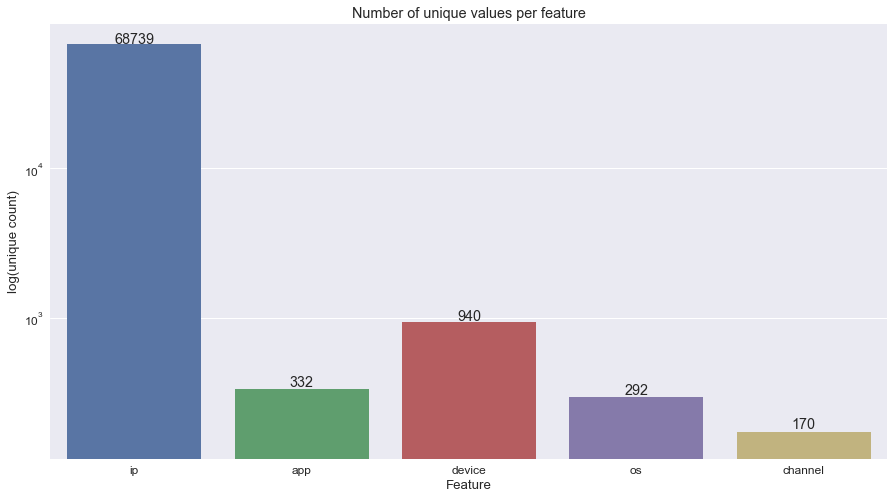

In [6]:
plt.figure(figsize=(15, 8))
cols = ['ip', 'app', 'device', 'os', 'channel'] 
uniques = [len(train[col].unique()) for col in cols] 
sns.set(font_scale=1.2) 
ax = sns.barplot(cols, uniques, palette=sns.color_palette(), log=True) 
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature') 
for p, uniq in zip(ax.patches, uniques): 
    height = p.get_height() 
    ax.text(p.get_x()+p.get_width()/2., height + 10, uniq, ha="center")

The ip has the highest number of unique values, followed by feature, os, app and channel. All the data given here are encoded for security reasons thus, we really cannot track the fraud, only we can have a brief idea of the unique value per feature.

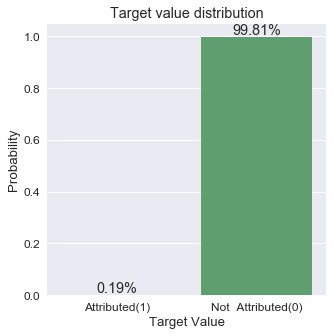

In [8]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.2) 
mean = (train.is_attributed.values == 1).mean() 
pal = sns.color_palette()
ax = sns.barplot(['Attributed(1)', 'Not  Attributed(0)'], [mean, 1-mean], palette=pal)
ax.set(xlabel='Target Value', ylabel='Probability', title='Target value distribution') 
for p, uniq in zip(ax.patches, [mean, 1-mean]): 
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+0.01, '{}%'.format(round(uniq * 100, 2)), ha="center")

This problem is a binary classification (0 and 1). Attributed (1) is our target value. We can see that only 0.19% of the total dataset is our target value. The dataset is highly imbalance.

In [9]:
#with train_data
train['click_time'] = pd.to_datetime(train['click_time'], errors='coerce')
train['day'] = train['click_time'].dt.day.astype('uint8')
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')
train.head()
#with test_data
test['click_time'] = pd.to_datetime(test['click_time'], errors='coerce')
test['day'] = test['click_time'].dt.day.astype('uint8')
test['hour'] = test['click_time'].dt.hour.astype('uint8')
test['minute'] = test['click_time'].dt.minute.astype('uint8')
test['second'] = test['click_time'].dt.second.astype('uint8')
test.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,119349,3,1,25,379,2017-11-06 15:48:09,NaN,0,6,15,48,9
1,102884,3,1,18,379,2017-11-06 15:48:11,NaN,0,6,15,48,11
2,121259,3,1,13,379,2017-11-06 15:48:18,NaN,0,6,15,48,18
3,2564,3,1,8,379,2017-11-06 15:48:21,NaN,0,6,15,48,21
4,35948,3,1,19,379,2017-11-06 15:48:22,NaN,0,6,15,48,22


In [10]:
print("Frequent hours")
frequent_hour = train.hour.value_counts().sort_index()
print(frequent_hour)
print("Frequent days")
frequent_day = train.day.value_counts().sort_index()
print(frequent_day)

Frequent hours
0      691681
15        234
16    2307777
17    1263348
18     738140
19     496354
20     409752
21     509572
22    1223530
23    2359612
Name: hour, dtype: int64
Frequent days
6    9308319
7     691681
Name: day, dtype: int64


We can see that hour 16, 12, 22, 30 is the maximum frequency of the the day for click time. The maximum likelihood of
the fraud click happens at that time. Thus, the click fraud detector has to been alert during the period. Below is 
the hour distribution in graph.

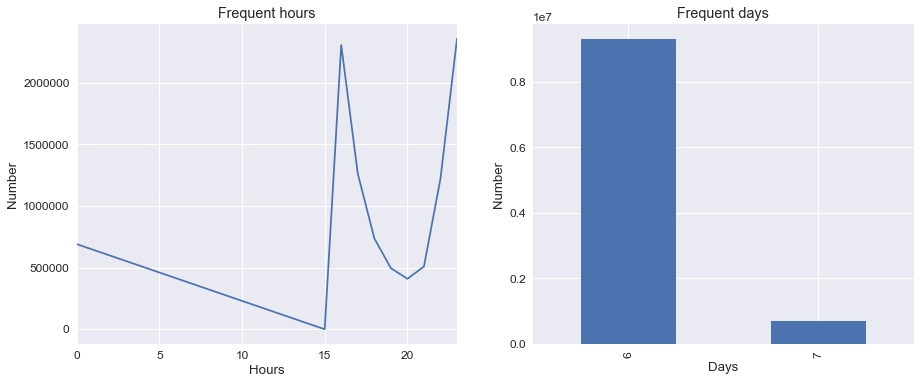

In [11]:
plt.figure(figsize=(15,20))

plt.subplot(321)
frequent_hour.plot(kind='line')
plt.title("Frequent hours")
plt.xlabel("Hours")
plt.ylabel("Number")

plt.subplot(322)
frequent_day.plot(kind='bar')
plt.title("Frequent days")
plt.xlabel("Days")
plt.ylabel("Number")

#some ips, apps, devices, etc. might have higher frequencies of is_attributed,
#calculate confidence value
#calculate count/total id
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ###############
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    
    # V2 Features #
    ###############
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    
    # V3 Features #
    ###############
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]

# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    train = train.merge(
        group_object['is_attributed']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'is_attributed': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
    
train.head()
#not favorable
#include model and feature, groupby

In [27]:

# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    #Count, ip, app
    {'groupby': ['ip','app'], 'select': 'channel', 'agg': 'count'}, 
    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'], 
     'select': 'ip', 
     'agg': lambda x: float(len(x)) / len(x.unique()), 
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}  
]

#for train_data
# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        train[new_feature] = gp[0].values
    else:
        train = train.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

train.head()
#test the features, how is it improving
#for test_data
# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = test[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        test[new_feature] = gp[0].values
    else:
        test = test.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

test.head()
#test the features, how is it improving

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'channel'], and aggregating hour with var
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['app'], and aggregating ip with AvgViewPerDistinct
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique
Grouping by ['ip', 'day'], and aggregating hour with nunique
Grouping by ['ip', 'app'], and aggregating os with nunique


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,...,ip_app_day_hour_count_channel,ip_app_channel_mean_hour,ip_app_count_channel,app_AvgViewPerDistinct_ip,app_count_channel,channel_count_app,ip_nunique_channel,ip_nunique_app,ip_day_nunique_hour,ip_app_nunique_os
0,119349,3,1,25,379,2017-11-06 15:48:09,NaN,0,6,15,...,4,19.225806,611,23.179895,1170237,161403,93,48,9,41
1,102884,3,1,18,379,2017-11-06 15:48:11,NaN,0,6,15,...,1,15.000000,4,23.179895,1170237,161403,16,14,7,3
2,121259,3,1,13,379,2017-11-06 15:48:18,NaN,0,6,15,...,1,7.500000,32,23.179895,1170237,161403,55,22,8,7
3,2564,3,1,8,379,2017-11-06 15:48:21,NaN,0,6,15,...,1,19.705882,342,23.179895,1170237,161403,84,34,9,32
4,35948,3,1,19,379,2017-11-06 15:48:22,NaN,0,6,15,...,1,19.750000,72,23.179895,1170237,161403,73,27,9,10


In [ ]:
GROUPBY_NEXTCLICK = [
     # V1 - GroupBy Features #
    #########################    
    # for ip
    {'groupby': ['ip']},
    # ip-app-os
    {'groupby': ['ip','app','os']},
    # for ip-day-channel
    {'groupby': ['ip','day','channel']},
    # for ip-app-day-hour
    {'groupby': ['ip','app','day','hour']},
    # for ip-app-channel
    {'groupby': ['ip','app','channel']}, 
    #grouping to look for identical click 
    {'groupby': ['ip','app']}, 
    {'groupby': ['ip','channel']}, 
    {'groupby': ['ip','os']},
    {'groupby': ['ip','app', 'device', 'os']},
    {'groupby': ['ip','os', 'device', 'app']},
    {'groupby': ['ip','os', 'device', 'app','channel']}   
    #ip and app for tracking for same app clicks
    #same clicks 'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'], #same app 'app_clicks': ['ip', 'app']
]
    
#for train_data
# Apply all the groupby transformations
for spec in GROUPBY_NEXTCLICK:
    
    # Name of new feature
    
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))
    # Info
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    train[new_feature] = train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
train.head()
#test the features, how is it improving
#for test_data
# Apply all the groupby transformations
for spec in GROUPBY_NEXTCLICK:
    
    # Name of new feature
    
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))
    # Info
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    test[new_feature] = test[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
test.head()

In [54]:
#Identical clicks among the variables
Identical_clicks= {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

#train_data
# Go through different group-by combinations
for fname, fset in Identical_clicks.items():
    
    # Clicks in the past
    train['prev_'+fname] = train. \
        groupby(fset). \
        cumcount(). \
        rename('prev_'+fname)
        
    # Clicks in the future
    train['future_'+fname] = train.iloc[::-1]. \
        groupby(fset). \
        cumcount(). \
        rename('future_'+fname).iloc[::-1]

# Count cumulative subsequent clicks
train.head()
#test
# Go through different group-by combinations
for fname, fset in Identical_clicks.items():
    
    # Clicks in the past
    test['prev_'+fname] = test. \
        groupby(fset). \
        cumcount(). \
        rename('prev_'+fname)
        
    # Clicks in the future
    test['future_'+fname] = test.iloc[::-1]. \
        groupby(fset). \
        cumcount(). \
        rename('future_'+fname).iloc[::-1]

# Count cumulative subsequent clicks
test.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,ip_confRate,app_confRate,...,ip_app_nextClick,ip_channel_nextClick,ip_os_nextClick,ip_app_device_os_nextClick,ip_os_device_app_nextClick,ip_os_device_app_channel_nextClick,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks
0,77553,24,1,17,105,2017-11-06 16:00:01,NaN,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,171396,15,1,9,245,2017-11-06 16:00:01,NaN,0,0.0,0.0,...,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0
2,35129,2,1,10,477,2017-11-06 16:00:01,NaN,0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,5.0,0,1,0,1
3,18890,12,1,19,265,2017-11-06 16:00:01,NaN,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,47455,8,1,19,145,2017-11-06 16:00:01,NaN,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,2


I have created different features, we can get deep into the features and get insight knowledge.